In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

## Section 1: Apply Rejections

In [3]:
## Load data.
data = read_csv(os.path.join('data','data.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data','reject.csv'))
data = data[data.subject.isin(reject.query('reject==0').subject)]

## Re-format columns.
data['outcome'] = data.outcome.replace({10:1, 1:0, -1:1, -10:0})

## Print subject numbers.
data.groupby('session').subject.nunique()

session
1    110
2     97
3     99
Name: subject, dtype: int64

In [4]:
data

subject  session  block runsheet  trial  exposure  \
0      02lqpjp4pevk73p8f7ipewf9        1      1       1b      1         1   
1      02lqpjp4pevk73p8f7ipewf9        1      1       1b      2         1   
2      02lqpjp4pevk73p8f7ipewf9        1      1       1b      3         1   
3      02lqpjp4pevk73p8f7ipewf9        1      1       1b      4         1   
4      02lqpjp4pevk73p8f7ipewf9        1      1       1b      5         2   
...                         ...      ...    ...      ...    ...       ...   
84475  zyflm7syc9jzpjpkv8k25xn3        3      2       3b    236         7   
84476  zyflm7syc9jzpjpkv8k25xn3        3      2       3b    237        10   
84477  zyflm7syc9jzpjpkv8k25xn3        3      2       3b    238        12   
84478  zyflm7syc9jzpjpkv8k25xn3        3      2       3b    239        10   
84479  zyflm7syc9jzpjpkv8k25xn3        3      2       3b    240         8   

      valence action robot  stimulus rune rune_set  correct  choice     rt  \
0         win     go    GW       1.0    W    bacs2        1       1  0.551   
1        lose  no-go  NGAL       2.0    X    bacs2        0       0    NaN   
2         win  no-go   NGW       0.0    J    bacs2        0       1  1.113   
3         win     go    GW       3.0    Z    bacs2        1       1  0.945   
4         win     go    GW       3.0    Z    bacs2        1       1  0.553   
...       ...    ...   ...       ...  ...      ...      ...     ...    ...   
84475     win     go    GW      11.0    Q  elianto        1       1  0.430   
84476    lose     go   GAL      10.0    N  elianto        1       1  0.484   
84477    lose  no-go  NGAL       8.0    X  elianto        0       0    NaN   
84478     win     go    GW       9.0    F  elianto        1       1  0.619   
84479     win     go    GW      11.0    Q  elianto        1       1  0.406   

       accuracy  sham  outcome  total_keys  
0             1   0.0        1           1  
1             1   0.0        1           0  
2             0   0.0        0           1  
3             1   0.0        1           1  
4             1   0.0        1           1  
...         ...   ...      ...         ...  
84475         1   0.0        1           1  
84476         1   0.0        1           1  
84477         1   0.0        1           0  
84478         1   0.0        1           1  
84479         1   0.0        1           1  

[73440 rows x 19 columns]

## Section 2: Overall Performance

#### 2.1 Learning Curves

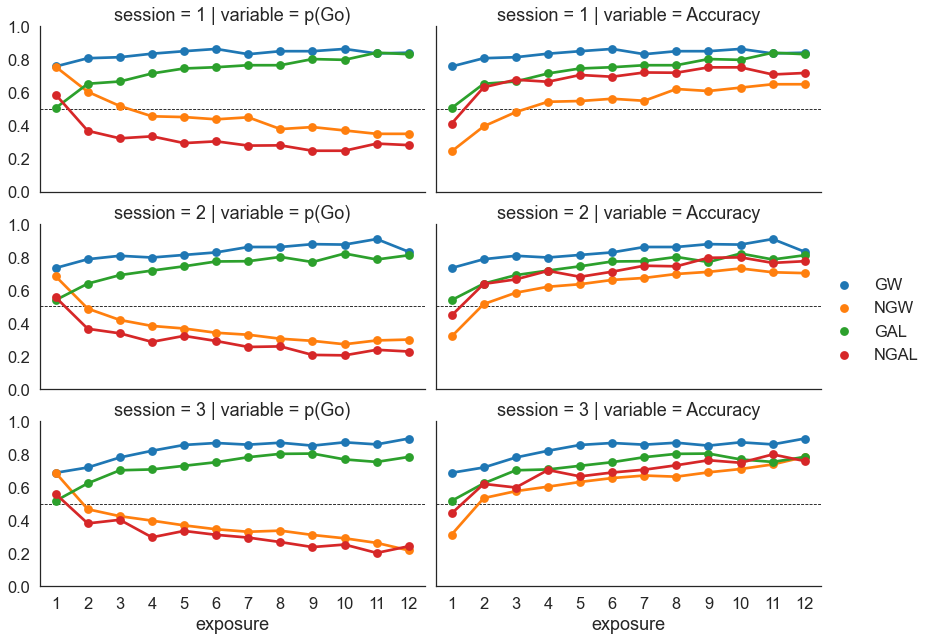

In [3]:
## Melt DataFrame.
melt = data.melt(id_vars=['session','robot','exposure'], value_vars=['choice','accuracy'])
melt.variable = melt.variable.replace({'choice':'p(Go)','accuracy':'Accuracy'})

## Initialize canvas.
g = sns.FacetGrid(melt, row='session', row_order=[1,2,3], col='variable', col_order=['p(Go)','Accuracy'], aspect=2)
palette = sns.color_palette(n_colors=4)

## Plot performance.
g.map(sns.pointplot, 'exposure', 'value', 'robot', order=np.arange(12)+1, hue_order=['GW','NGW','GAL','NGAL'],
      palette=palette, ci=None)

## Add details.
for ax in g.axes.flatten(): ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)
g.set(ylim=(0,1), ylabel='')
g.add_legend();

#### 2.2 Individual Differences (Within Sessions)

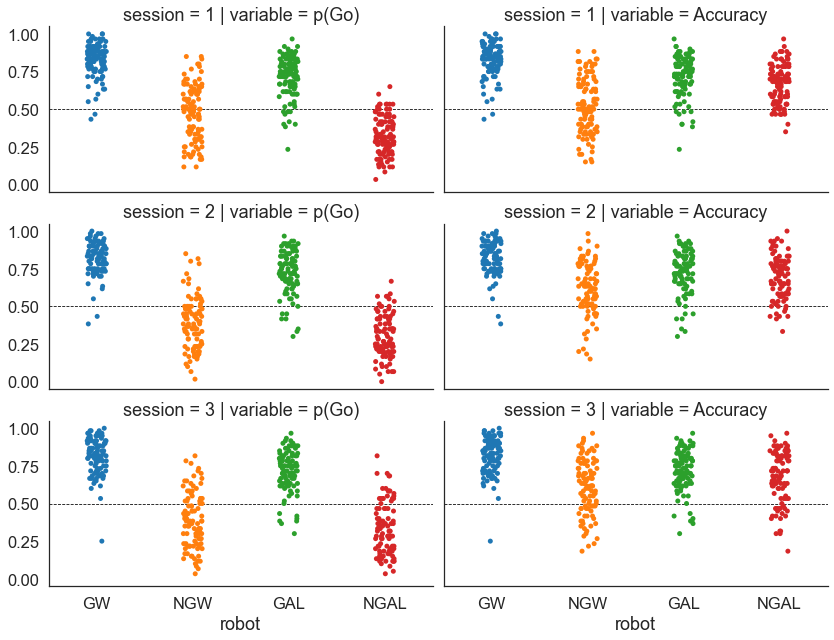

In [4]:
## Melt DataFrame.
melt = data.melt(id_vars=['subject','session','robot','exposure'], value_vars=['choice','accuracy'])
melt = melt.groupby(['subject','session','robot','variable']).value.mean().reset_index()
melt.variable = melt.variable.replace({'choice':'p(Go)','accuracy':'Accuracy'})

## Initialize canvas.
g = sns.FacetGrid(melt, row='session', row_order=[1,2,3], col='variable', col_order=['p(Go)','Accuracy'], aspect=2)
palette = sns.color_palette(n_colors=4)

## Plot performance.
g.map(sns.stripplot, 'robot', 'value', order=['GW','NGW','GAL','NGAL'], palette=palette)

## Add details.
for ax in g.axes.flatten(): ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)
g.set(ylim=(-0.05,1.05), ylabel='');

#### 3.3 Individual Differences (Across Sessions)

In [5]:
## Initialize canvas.
fig, axes = plt.subplots(3,4,figsize=(14,8),sharey=True)
axes = np.atleast_2d(axes)
palette = sns.color_palette(n_colors=4).as_hex()

## Compute average within subjects.
gb = data.groupby(['subject','session','robot']).accuracy.mean().reset_index()
gb = gb.pivot_table('accuracy', 'subject', ['robot','session'])

## Iterate over conditions.
for i, (robot, color) in enumerate(zip(['GW','NGW','GAL','NGAL'], palette)):
    
    for j, (x, y) in enumerate(zip([1,1,2],[2,3,3])):
    
        ## Plot session comparison.
        sns.scatterplot(x='x', y='y', data=gb[robot].rename(columns={x:'x', y:'y'}), color=color, ax=axes[j,i])
        
        ## Add detail.
        axes[j,i].plot([-2,2],[-2,2],lw=0.8,linestyle='--',color='k',zorder=-1)
        axes[j,i].set(xlim=(-0.05,1.05), ylim=(-0.05,1.05), xlabel=f'Session {x}')
        if not i: axes[j,i].set_ylabel(f'Session {y}')
        if not j: axes[j,i].set_title(f'Accuracy | {robot}')
    
sns.despine()
plt.tight_layout()

## Section 3: Block Effects

#### 3.1 Learning Curves

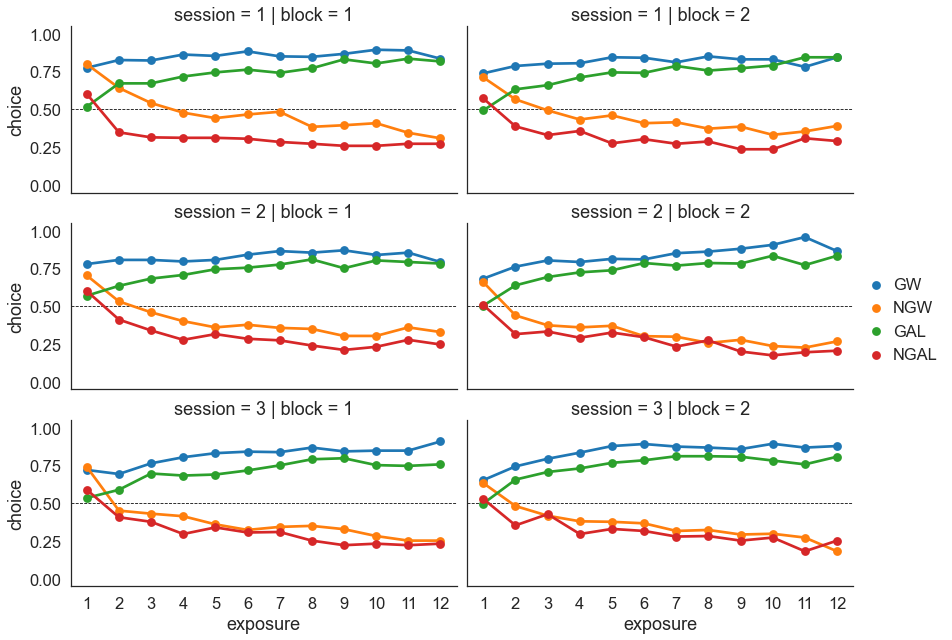

In [6]:
## Initialize canvas.
g = sns.FacetGrid(data, row='session', row_order=[1,2,3], col='block', col_order=[1,2], aspect=2)
palette = sns.color_palette(n_colors=4)

## Plot performance.
g.map(sns.pointplot, 'exposure', 'choice', 'robot', order=np.arange(12)+1,
      hue_order=['GW','NGW','GAL','NGAL'], palette=palette, ci=None)

## Add details.
g.set(ylim=(-0.05,1.05))
g.add_legend(handletextpad=0)
for ax in axes[:,0]: ax.set_ylabel('p(Go)')
for ax in g.axes.flatten(): ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)

#### 3.2 Individual Differences (Within Sessions)

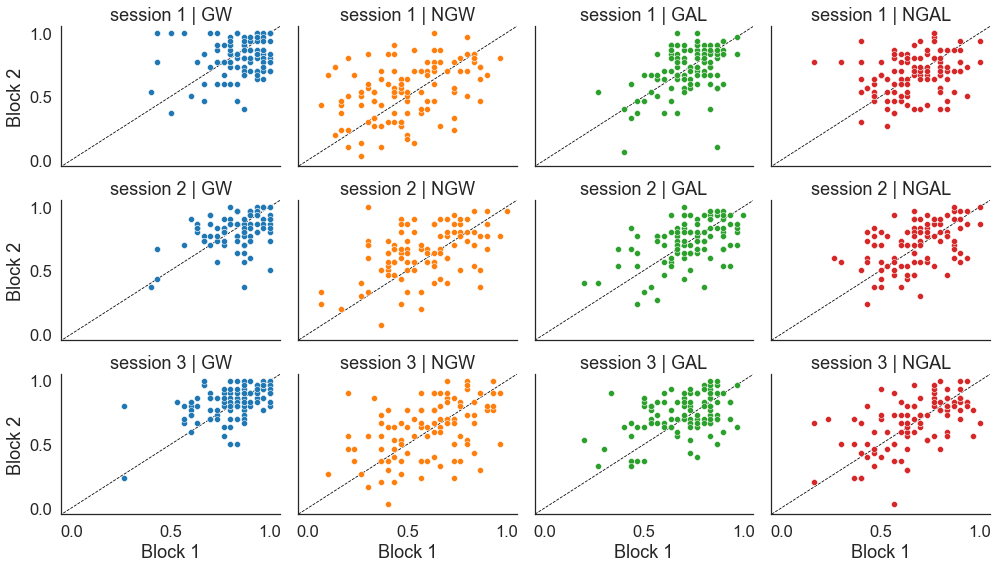

In [7]:
## Initialize canvas.
fig, axes = plt.subplots(3,4,figsize=(14,8),sharex=True,sharey=True)
palette = sns.color_palette(n_colors=4).as_hex()

## Compute average within subjects.
gb = data.groupby(['subject','session','block','robot']).accuracy.mean().reset_index()
gb = gb.pivot_table('accuracy',['session','subject'],['robot','block'])

## Iterate over sessions.
for i, session in enumerate(data.session.unique()):
    
    for j, (robot, color) in enumerate(zip(['GW','NGW','GAL','NGAL'], palette)):
    
        ## Plot performance.
        sns.scatterplot(x='x', y='y', data=gb.loc[session,robot].rename(columns={1:'x', 2:'y'}), 
                        color=color, ax=axes[i,j])

        ## Add details.y
        axes[i,j].plot([-2,2],[-2,2],lw=0.8,linestyle='--',color='k',zorder=-1)
        axes[i,j].set(xlim=(-0.05,1.05), xlabel='Block 1', ylim=(-0.05,1.05), ylabel='Block 2', 
                      title=f'session {session} | {robot}')
    
sns.despine()
plt.tight_layout()

## Section 4: Character Set Effects

#### 4.1 Learning Curves

In [8]:
## Initialize canvas.
g = sns.FacetGrid(data, row='session', col='rune_set', col_order=['elianto','bacs1','bacs2'], aspect=1.5)
palette = sns.color_palette(n_colors=4)

## Plot performance.
g.map(sns.pointplot, 'exposure', 'accuracy', 'robot', order=np.arange(12)+1,
      hue_order=['GW','NGW','GAL','NGAL'], palette=palette, ci=None)

## Add details.
g.set(ylim=(-0.05,1.05))
g.add_legend(handletextpad=0)
for ax in g.axes.flatten(): ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)

#### 4.2 Individual Differences

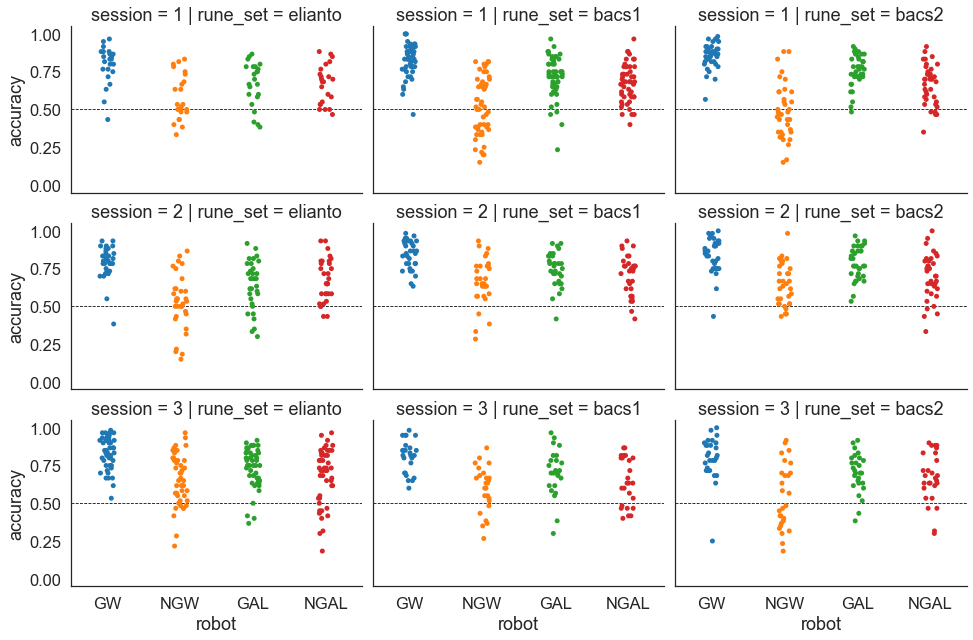

In [9]:
## Compute average within subjects.
gb = data.groupby(['session','subject','rune_set','robot']).accuracy.mean().reset_index()

## Initialize canvas.
g = sns.FacetGrid(gb, row='session', col='rune_set', col_order=['elianto','bacs1','bacs2'], aspect=1.5)
palette = sns.color_palette(n_colors=4)

## Plot performance.
g.map(sns.stripplot, 'robot', 'accuracy', order=['GW','NGW','GAL','NGAL'], palette=palette)

## Add detail.
g.set(ylim=(-0.05,1.05))
for ax in g.axes.flatten(): ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)

## Section 5: Learning Effects

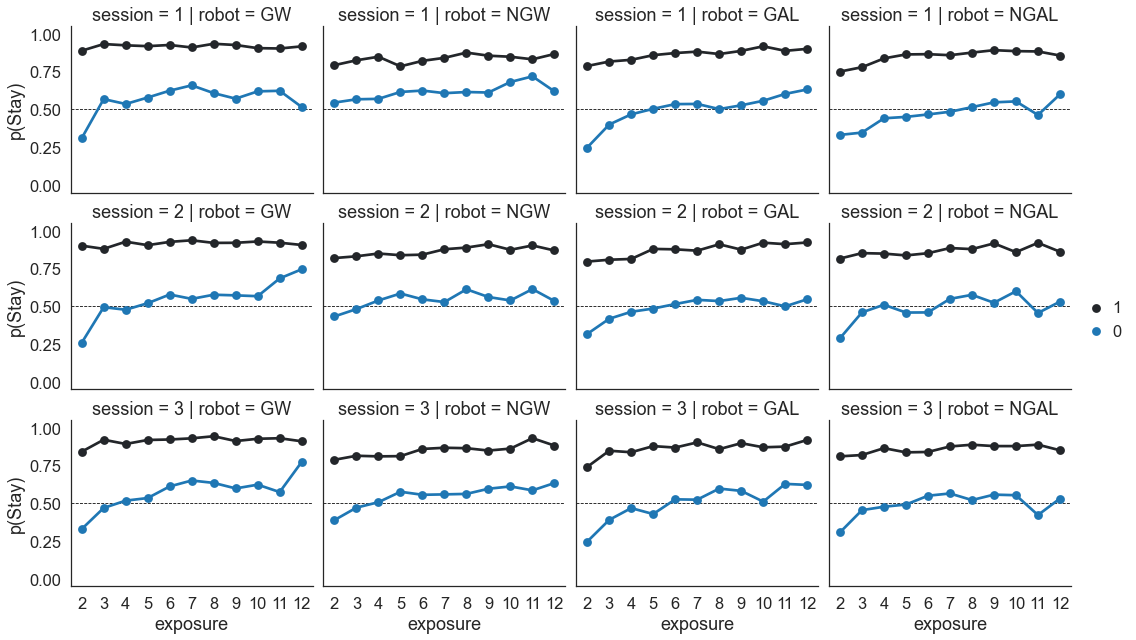

In [10]:
## Re-format data.
data = data.sort_values(['session','subject','block','rune','exposure']).reset_index(drop=True)

## Define previous choice / outcome.
data['prev_choice']  = np.roll(data.choice, 1)
data['prev_outcome'] = np.roll(data.outcome, 1)

## Define stay.
data['p(Stay)'] = np.where(data['choice']==data['prev_choice'], 1, 0)

## Mask first exposure.
data.loc[data.exposure==1, ['prev_choice','prev_outcome','p(Stay)']] = np.nan

## Initialize canvas.
g = sns.FacetGrid(data, row='session', col='robot', col_order=['GW','NGW','GAL','NGAL'], aspect=1.25)

## Plot performance.
g.map(sns.pointplot, 'exposure', 'p(Stay)', 'prev_outcome', order=np.arange(2,13), 
      hue_order=[1,0], ci=None)

## Add details.
g.set(ylim=(-0.05,1.05))
g.add_legend(handletextpad=0)
for ax in g.axes.flatten(): ax.axhline(0.5, lw=0.8, linestyle='--', color='k', zorder=-1)

## Section 6: Response Times

#### 6.1: Go Trials

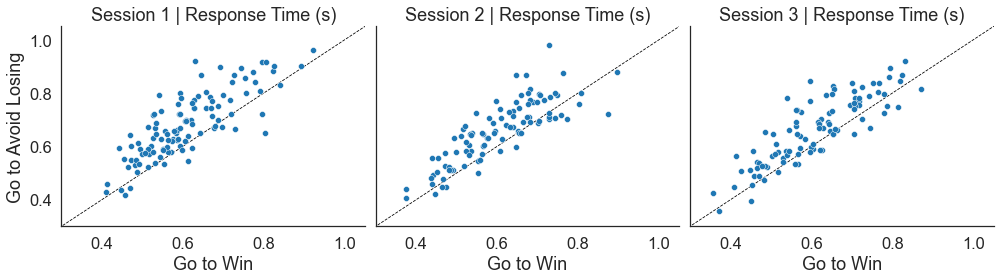

In [11]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(14,4),sharex=True,sharey=True)
palette = ['#1f77b4', '#2ca02c']

## Compute median response time within session / subject / robot.
gb = data.query('action=="go"').groupby(['session','subject','robot']).rt.median().reset_index()
gb = gb.pivot_table('rt', ['subject','session'], 'robot')

for ax, session in zip(axes, [1,2,3]):
    
    ## Plot response times.
    sns.scatterplot(x='GW', y='GAL', data=gb.query(f'session=={session}'), ax=ax)
    
    ## Add details.
    ax.plot([0,1.3],[0,1.3],lw=0.8,linestyle='--',color='k',zorder=-1)
    ax.set(xlim=(0.3,1.05), xlabel='Go to Win', ylim=(0.3,1.05), ylabel='Go to Avoid Losing',
           title=f'Session {session} | Response Time (s)')
    
sns.despine()
plt.tight_layout()

## Section 7: Self-Report Data

In [3]:
from pandas import DataFrame

## Load data.
surveys = read_csv(os.path.join('data','surveys.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data','reject.csv'))
surveys = surveys[surveys.subject.isin(reject.query('reject==0').subject)]

## Extract item columns.
cols = np.concatenate([surveys.filter(regex=f'{p}_q').columns[:-1] for p in ['gad7','dass','bisbas']])
cols = np.append('mood',cols)

## Construct items matrix.
items = surveys[cols].copy()

## Construct sum scores.
scores = DataFrame({p: items.filter(regex=p).sum(axis=1) for p in ['mood','gad7','dass','bisbas']})
scores.insert(0, 'subject', surveys.subject)
scores.insert(1, 'session', surveys.session)
scores.loc[scores.session > 1, 'bisbas'] = np.nan

#### 7.1 Sum scores

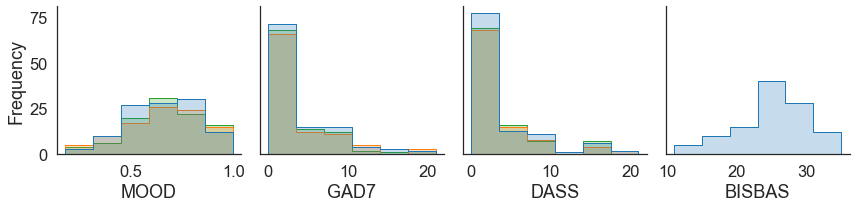

In [4]:
## Initialize canvas.
fig, axes = plt.subplots(1,4,figsize=(12,3),sharey=True)
palette = sns.color_palette(n_colors=3)

## Iteratively plot sum scores.
for ax, p in zip(axes, ['mood','gad7','dass','bisbas']):
    
    ## Plot distribution.
    sns.histplot(x=p, hue='session', data=scores, bins=6, palette=palette, element='step', ax=ax)
    
    ## Add details.
    ax.set(xlabel=p.upper(), ylabel='Frequency')
    ax.legend_.set_visible(False)
    
sns.despine()
plt.tight_layout()

#### 7.2 Item-level correlations

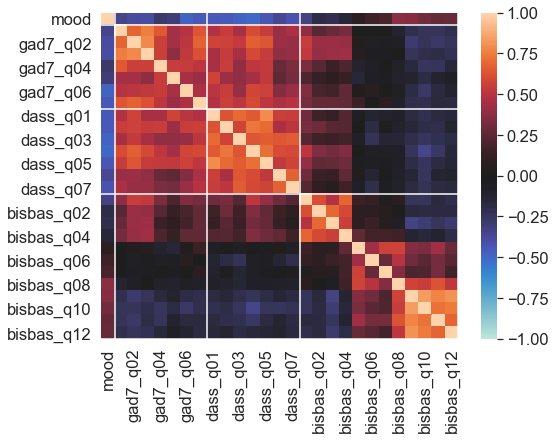

In [14]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,6))
div = np.cumsum([items.filter(regex=p).shape[1] for p in ['mood','gad7','dass','bisbas']])

## Plot heatmap.
sns.heatmap(items.corr(method='spearman'), vmin=-1, vmax=1, center=0, ax=ax)
ax.vlines(div, 0, div.max(), color='1.0')
ax.hlines(div, 0, div.max(), color='1.0');

#### 7.3 Individual Differences (Across Sessions)

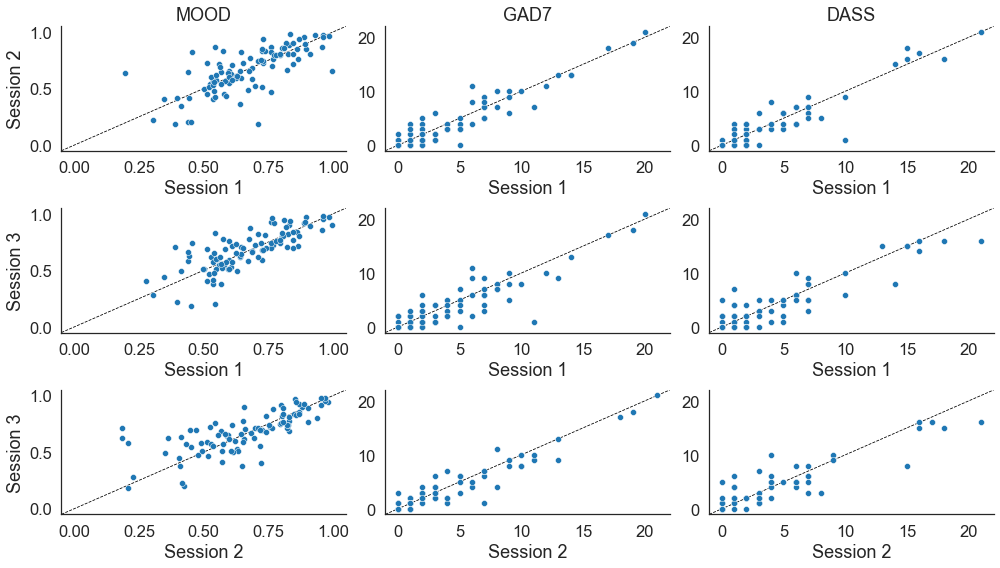

In [15]:
## Initialize canvas.
fig, axes = plt.subplots(3,3,figsize=(14,8))

## Construct pivot table.
gb = scores.pivot_table(index='subject', columns='session')

## Iterate over conditions.
for i, (measure, lims) in enumerate(zip(['mood','gad7','dass'], [(-0.05,1.05),[-1,22],[-1,22]])):
    
    for j, (x, y) in enumerate(zip([1,1,2],[2,3,3])):
    
        ## Plot session comparison.
        sns.scatterplot(x='x', y='y', data=gb[measure].rename(columns={x:'x', y:'y'}), color='#1f77b4', ax=axes[j,i])
        
        ## Add details.
        axes[j,i].plot(lims, lims, lw=0.8,linestyle='--',color='k',zorder=-1)    
        axes[j,i].set(xlim=lims, xlabel=f'Session {x}', ylim=lims, ylabel='')
        if not i: axes[j,i].set_ylabel(f'Session {y}')
        if not j: axes[j,i].set_title(measure.upper())
    
sns.despine()
plt.tight_layout()

## Section 8: Metadata

In [16]:
## Load data.
metadata = read_csv(os.path.join('data','metadata.csv'))

## Apply rejections.
reject = read_csv(os.path.join('data','reject.csv'))
metadata = metadata[metadata.subject.isin(reject.query('reject==0').subject)]

#### 8.1 Self-Report Ratings

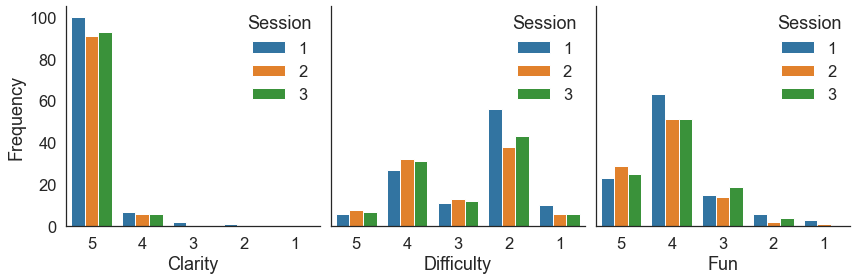

In [17]:
## Initialize canvas.
fig, axes = plt.subplots(1,3,figsize=(12,4),sharex=True,sharey=True)

## Iterate over categories.
for i, (ax, var) in enumerate(zip(axes, ['clarity','difficulty','fun'])):
    
    ## Plot ratings.
    sns.countplot(x=var, hue='session', data=metadata, order=[5,4,3,2,1],  ax=ax)
    
    ## Add detail.
    ax.set(xlabel=var.capitalize(), ylabel='Frequency' if not i else '')
    ax.legend(loc=1, frameon=False, title='Session', borderpad=0)
    
sns.despine()
plt.tight_layout()

## Section 9: Missing Data Analysis

#### 9.1 Missing Data by First Rating

<AxesSubplot:ylabel='Count'>

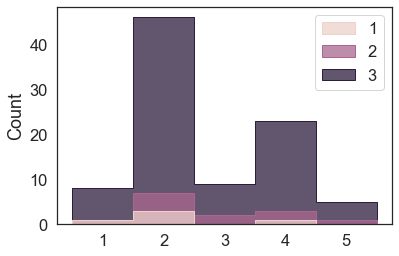

In [18]:
## Compute number of sessions available per participant.
x = data.groupby('subject').session.nunique().values

## Compute accuracy in first session.
y = metadata.query('session==1').difficulty.values

sns.histplot(x=y, hue=x, element='step', bins=np.arange(6)+0.5)

#### 9.2 Missing Data by First Performance 

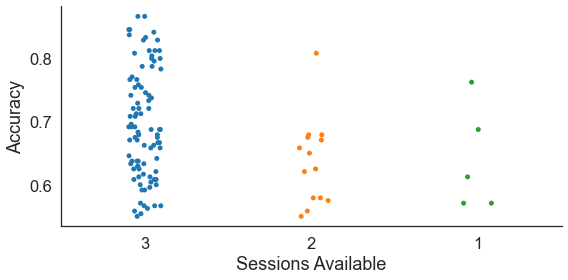

In [19]:
## Compute number of sessions available per participant.
x = data.groupby('subject').session.nunique().values

## Compute accuracy in first session.
y = data.query('session==1').groupby('subject').accuracy.mean()

## Initialize canvas. 
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot accuracy by sessions available.
sns.stripplot(x=x, y=y, order=[3,2,1], ax=ax)
ax.set(xlabel='Sessions Available', ylabel='Accuracy')

sns.despine()
plt.tight_layout()